## Running hyperparameter optimization - Part 1

This notebook goes through part one of the steps and codes for identifying the optimal hyperparameter settings for the Variational Autoencoder framework for integrating multi-omics and clinical data spanning both categorical and continuous variables. <br>

The optimal settings are identified based on multiple steps cosidering both reconstruction on the test and training sets as well as the stability/similiarity of the latent space in case of repeated training. Part one focus on the test and training reconstruction accuracies. The result of the script will be plots for vizualising the comparisons for manual selection of the optimal combination for the use case of the data. Based on these select the top performing settings to run the stability analysis in <i>MOVE_hyperparameter_optimization_stability.ipynb</i>. Before running this make sure you have your data encoded correctly - check <i>encode_data.ipynb</i>.

In [2]:
# !pip install umap
# !pip install seaborn

In [3]:
# Import functions
import os, sys
import torch
import numpy as np
from torch.utils import data
import copy

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset

import umap
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from scipy.stats.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib
import re
import random
from collections import defaultdict

path="/"
sys.path.append(path + "src/")
import VAE_v2_1

/home/valentas/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


Below are the funcitons for reading data, calculating and saving result defiend

In [4]:
# Functions for reading data
def read_cat(file):
   data = np.load(file)
   data = data.astype(np.float32)
   data_input = data.reshape(data.shape[0], -1)
   
   return data, data_input

def read_con(file):
   
   data = np.load(file)
   data = data.astype(np.float32)
   data[np.isnan(data)] = 0
   consum = data.sum(axis=0)
   mask_col = consum != 0
   data = data[:,mask_col]
   return data, mask_col

def read_header(file, mask=None, start=1):
   with open(file, "r") as f:
      h = f.readline().rstrip().split("\t")[start:]
   if not mask is None:
      h = np.array(h)
      h = h[mask]
   
   return h

In [5]:
# Funtions for calculations

def get_latent(best_model, train_loader, test_loader, kld_w):
   # Get training set results
   train_test_loader = DataLoader(dataset=train_loader.dataset, batch_size=1, drop_last=False, shuffle=False) #, num_workers=1, pin_memory=train_loader.pin_memory

   latent, latent_var, cat_recon, cat_class, con_recon, loss, likelihood = best_model.latent(train_test_loader, kld_w)
   con_recon = np.array(con_recon)

   con_recon = torch.from_numpy(con_recon)
   
   # Get test set results
   test_loader = DataLoader(dataset=test_loader.dataset, batch_size=1, drop_last=False, shuffle=False) #, num_workers=1, pin_memory=test_loader.pin_memory
   latent_test, latent_var_test, cat_recon_test, cat_class_test, con_recon_test, loss_test, likelihood_test = best_model.latent(test_loader, kld_w)
   con_recon_test = np.array(con_recon_test)
   con_recon_test = torch.from_numpy(con_recon_test)
   
   return con_recon, train_test_loader, latent, latent_var, cat_recon, cat_class, loss, likelihood, latent_test, latent_var_test, cat_recon_test, cat_class_test, con_recon_test, loss_test, likelihood_test

def cal_recon(cat_shapes, cat_recon, cat_class, train_loader, con_recon, con_shapes, cat_recon_test, cat_class_test, test_loader, con_recon_test):
   cat_true_recon = cal_cat_recon(cat_shapes, cat_recon, cat_class)
   true_recon = cal_con_recon(train_loader, con_recon, con_shapes)
   cat_true_recon_test = cal_cat_recon(cat_shapes, cat_recon_test, cat_class_test)
   true_recon_test = cal_con_recon(test_loader, con_recon_test, con_shapes)
   
   return cat_true_recon,true_recon,cat_true_recon_test,true_recon_test

def plot_graphs():
   fig = plt.figure()
   plt.plot(epochs, loss, '-g', label='loss')
   plt.plot(epochs, ce, '-b', label='CE')
   plt.plot(epochs, sse, '-r', label='SSE')
   plt.plot(epochs, KLD, '-y', label='KLD')
   plt.legend()
   plt.savefig(path + "/evaluation/loss_" + combi +".png")
   plt.clf()
   
   fig = plt.figure()
   plt.plot(epochs, loss, '-b', label='loss')
   plt.plot(batchsteps, loss_test, '-r', label='test loss')
   plt.legend()
   plt.savefig(path + "/evaluation/test_loss_" + combi +".png")
   plt.clf()

def save_input(combi,cat_true_recon,true_recon,latent,con_recon,cat_recon,loss,likelihood,best_epoch,cat_true_recon_test,true_recon_test,latent_test,con_recon_test,cat_recon_test,loss_test,likelihood_test):
  recon_acc[combi].append(cat_true_recon + true_recon)
  latents[combi].append(latent)
  con_recons[combi].append(con_recon)
  cat_recons[combi].append(cat_recon)
  loss_train[combi].append(loss)
  likelihoods[combi].append(likelihood)
  best_epochs[combi].append(best_epoch)
  
  recon_acc_tests[combi].append(cat_true_recon_test + true_recon_test)
  latents_tests[combi].append(latent_test)
  con_recons_tests[combi].append(con_recon_test)
  cat_recons_tests[combi].append(cat_recon_test)
  loss_tests[combi].append(loss_test)
  likelihood_tests[combi].append(likelihood_test)

def cal_cat_recon(cat_shapes, cat_recon, cat_class):
   cat_true_recon = []
   cat_total_recon = []
   pos = 0
   for s in cat_shapes:
      n = s[1]
      cat_class_tmp = cat_class[:,pos:(n + pos)]
      cat_recon_tmp = cat_recon[:,pos:(n + pos)]
      
      missing_cat = cat_recon_tmp[cat_class_tmp == -1]
      diff_cat = cat_class_tmp - cat_recon_tmp
      
      diff_cat[diff_cat != 0] = -1
      true_cat = diff_cat[diff_cat == 0]
      false_cat = diff_cat[diff_cat != 0]
      cat_true = len(true_cat)/(float(diff_cat.size) - missing_cat.size)
      cat_true_recon.append(cat_true)
      diff_cat[diff_cat == 0] = 1
      diff_cat[diff_cat != 1] = 0
      cat_total_recon.append(np.count_nonzero(diff_cat, 1) / diff_cat.shape[1])
      pos += n
   return cat_true_recon

def cal_con_recon(train_loader, con_recon, con_shapes):
   total_shape = 0
   true_recon = []
   cos_values = []
   all_values = []
   for s in con_shapes:
      cor_con = list()
      cos_con = list()
      all_val =list()
      for n in range(0, con_recon.shape[0]):
         con_no_missing = train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)][train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]
         if len(con_no_missing) <= 1:
            all_val.append(np.nan)
            continue
         con_out_no_missing = con_recon[n,total_shape:(s + total_shape - 1)][train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]
         


         cor = pearsonr(con_no_missing, con_out_no_missing)[0]
         cor_con.append(cor)
         
         com = np.vstack([con_no_missing, con_out_no_missing])
         cos = cosine_similarity(com)[0,1]
         cos_con.append(cos)
         all_val.append(cos)
      
      cor_con = np.array(cor_con)
      cos_con = np.array(cos_con)
      cos_values.append(cos_con)
      all_values.append(np.array(all_val))
      true_recon.append(len(cos_con[cos_con >= 0.7]) / len(cos_con))
      total_shape += s
      
   return true_recon

The next part is for reading in the data. This example uses the different datatypes included in the publication of MOVE which consist of three categorical datatypes and seven continuous. NOTE the data is not availble for testing. 

In [6]:
path = './'
# Read in categorical data
cat, cat_input = read_cat(path + "data/baseline_categorical.npy")
cat_h = read_header(path + "data/baseline_categorical.tsv")

geno, geno_input = read_cat(path + "data/diabetes_genotypes.npy")
geno_h = read_header(path + "data/diabetes_genotypes.tsv")

drug, drug_input = read_cat(path + "data/baseline_drugs.npy")
drug_h = read_header(path + "data/baseline_drugs.tsv")


# Read in continuous data
con, con_mask = read_con(path + "data/baseline_continuous.npy")
con_h = read_header(path + "data/baseline_continuous.tsv", con_mask)

diet_wearables, con_mask = read_con(path + "data/baseline_diet_wearables.npy")
diet_wearables_h = read_header(path + "data/baseline_diet_wearables.tsv", con_mask)

pro, con_mask = read_con(path + "data/baseline_proteomic_antibodies.npy")
pro_h = read_header(path + "data/baseline_proteomic_antibodies.tsv", con_mask)
pro_h = [s + "_pro" for s in pro_h] # due to overlap in gene names form transcriptomics data

target_mata, con_mask = read_con(path + "data/baseline_target_metabolomics.npy")
targm_h = read_header(path + "data/baseline_target_metabolomics.tsv", con_mask)

untarget_mata, con_mask = read_con(path + "data/baseline_untarget_metabolomics.npy")
untargm_h = read_header(path + "data/baseline_untarget_metabolomics.tsv", con_mask)

trans, con_mask = read_con(path + "data/baseline_transcriptomics.npy")
tran_h = read_header(path + "data/baseline_transcriptomics.tsv", con_mask)

metagen, con_mask = read_con(path + "data/baseline_metagenomics.npy")
meta_h = read_header(path + "data/baseline_metagenomics.tsv", con_mask)

In [7]:
# combined headers
con_names = np.concatenate((con_h, diet_wearables_h, pro_h, targm_h, untargm_h, tran_h, meta_h))
cat_names = np.concatenate((cat_h, geno_h, drug_h))

The data is then divided into af 90% training set and a 10% test set to evaluate the hyper-parameters

In [8]:
import os
isExist = os.path.exists(path + 'hyperparameters/')
if not isExist:
    os.makedirs(path + 'hyperparameters/')
    

# Divide into test and training set
npatient = cat.shape[0]
train = random.sample(range(npatient), int(npatient*0.90))
test = list(set(range(npatient)) - set(train))

# Define list for input to the VAE
con_list = [con[train], diet_wearables[train], pro[train], target_mata[train], untarget_mata[train], trans[train], metagen[train]]
cat_list = [cat[train], geno[train]]

con_list_test = [con[test], diet_wearables[test], pro[test], target_mata[test], untarget_mata[test], trans[test], metagen[test]]
cat_list_test = [cat[test], geno[test]]

# The selections are are saved
np.save(path + "hyperparameters/train1.npy", np.array(train))
np.save(path + "hyperparameters/test1.npy", np.array(test))

The dataloader for the two dataset are defined

In [9]:
mask_test, test_loader = VAE_v2_1.make_dataloader(cat_list=cat_list_test, con_list=con_list_test, batchsize=1)
test_loader = DataLoader(dataset=test_loader.dataset, batch_size=1, drop_last=False, shuffle=False) #, num_workers=1, pin_memory=test_loader.pin_memory

mask, train_loader = VAE_v2_1.make_dataloader(cat_list=cat_list, con_list=con_list, batchsize=10)

ncontinuous = train_loader.dataset.con_all.shape[1]
con_shapes = train_loader.dataset.con_shapes

ncategorical = train_loader.dataset.cat_all.shape[1]
cat_shapes = train_loader.dataset.cat_shapes


In [10]:
# Set this to true if the code runs on GPU
cuda = False #True
device = torch.device("cuda" if cuda == True else "cpu")

The hyperparameters tested are defiend below. For this part a selection of fitting values needs to be selected for the specific dataset. The search is here for a full grid search but the code can be modified for sampling if needed. 

In [11]:
nHiddens = [500, 1000]
nLatents = [20, 50]
nLayers = [1, 2]
nDropout = [0.1, 0.2]
nBeta = [0.00001, 0.0001]
# nHiddens = [500, 1000, 2000]
# nLatents = [20, 50, 100, 200, 400]
# nLayers = [1, 2, 3]
# nDropout = [0.1, 0.2, 0.3]
# nBeta = [0.00001, 0.0001, 0.001]


batch_sizes = [10]
#batch_sizes = [5, 7, 10, 15]
repeat = 1 # for analysing the stability for repeated training (used late for less hyperparameters in this case)

In [12]:
# Create objects to save results
#embeddings = defaultdict(list)
latents = defaultdict(list)
con_recons = defaultdict(list)
cat_recons = defaultdict(list)
recon_acc = defaultdict(list)
loss_train = defaultdict(list)
likelihoods = defaultdict(list)
models = defaultdict()
best_epochs = defaultdict(list)

latents_tests = defaultdict(list)
con_recons_tests = defaultdict(list)
cat_recons_tests = defaultdict(list)
recon_acc_tests = defaultdict(list)
loss_tests = defaultdict(list)
likelihood_tests = defaultdict(list)

Before running the training loop the steps for updating the KLD weight (for KDL warm-up - read paper for more informaiton) as well as increase in batch size is set. The code runs with early stopping in case of increase error on the test set for more than and the epoch with the best result is saved.  

In [13]:
nepochs=500
lrate=1e-3
kldsteps=[20, 30, 40, 90]
batchsteps=[50, 100, 150, 200, 250, 300, 350, 400, 450]
l = len(kldsteps)
r = 20/l
epochs = range(1, nepochs + 1)

The training loop for the full grid search of hyperparameters

In [13]:
for nHidden in nHiddens:
   for nLatent in nLatents:
      for nl in nLayers:
         for drop in nDropout:
            for b in nBeta:
               for batch_size in batch_sizes:
                  for r in range(repeat):
                     combi = str([nHidden] * nl) + "+" + str(nLatent) + ", drop: " + str(drop) + ", b: " + str(b) + ", batch: " + str(batch_size)
                     print(combi)
                     
                     # Initiate loader
                     mask, train_loader = VAE_v2_1.make_dataloader(cat_list=cat_list, con_list=con_list, batchsize=batch_size)
                        
#                      print(next(iter(train_loader)))
                     # Initate model
                     model = VAE_v2_1.VAE(ncategorical=ncategorical, ncontinuous= ncontinuous,
                                       con_shapes=con_shapes, cat_shapes=cat_shapes, nhiddens=[nHidden]*nl,
                                       nlatent=nLatent,  beta=b, con_weights=[1,1,1,1,1,1,1],
                                       cat_weights=[1,1], dropout=drop, cuda=False).to(device) # removed alpha=0.01,
                     
                     # Create lists for saving loss
                     loss = list();ce = list();sse = list();KLD = list();loss_test = list()
                     
                     # Train model
                     lrate=1e-3
                     kld_w = 0
                     update = 1 + r
#                      l_min = 1000000
                     l_min = None
                     count = 0
                     for epoch in range(1, nepochs + 1):
                        if epoch in kldsteps:
                           kld_w = 1/20 * update
                           #lrate = lrate - lrate*0.1
                           update += r
                        
                        if epoch in batchsteps:
                           train_loader = DataLoader(dataset=train_loader.dataset,batch_size=int(train_loader.batch_size * 1.5),shuffle=True,drop_last=True) #,num_workers=train_loader.num_workers,pin_memory=train_loader.pin_memory

                        l, c, s, k = model.encoding(train_loader, epoch, lrate, kld_w)
                        
                        out = model.latent(test_loader, kld_w)
                        loss_test.append(out[-2])
                        print("Likelihood: " + str(out[-1]))
                        
                        loss.append(l)
                        ce.append(c)
                        sse.append(s)
                        KLD.append(k)
                        
                        if (l_min != None and out[-1] > l_min) and count < 2: #Changed from 100 ### Having very low count number, sometimes decoder returned inf or nan values; 
                           count += 1
                           if count % 5 == 0:
                              lrate = lrate - lrate*0.10
                        
                        elif count == 2: #Changed from 100
                           break
                        
                        else:
                           l_min = out[-1]
                           best_model = copy.deepcopy(model)
                           best_epoch = epoch
                           count = 0
                           
                           if epoch > 3:
                              break
                     
                     # get results
                     con_recon, train_test_loader, latent, latent_var, cat_recon, cat_class, loss, likelihood, latent_test, latent_var_test, cat_recon_test, cat_class_test, con_recon_test, loss_test, likelihood_test = get_latent(best_model, train_loader, test_loader, kld_w)
                     
                     # Calucalte reconstruction
#                      print(con_recon.shape)
                     cat_true_recon,true_recon,cat_true_recon_test,true_recon_test = cal_recon(cat_shapes, cat_recon, cat_class, train_loader, con_recon, con_shapes, cat_recon_test, cat_class_test, test_loader, con_recon_test)
                     # Save output
                     save_input(combi,cat_true_recon,true_recon,latent,con_recon,cat_recon,loss,likelihood,best_epoch,cat_true_recon_test,true_recon_test,latent_test,con_recon_test,cat_recon_test,loss_test,likelihood_test)
                     


[500]+20, drop: 0.1, b: 1e-05, batch: 10
	Epoch: 1	Loss: 10822.614134	CE: 2.9136124	SSE: 10819.700498	KLD: 0.0000	Batchsize: 10
====> Test set loss: 10759.4844
Likelihood: 849999.2580835348
	Epoch: 2	Loss: 10414.636485	CE: 2.8989404	SSE: 10411.737539	KLD: 0.0000	Batchsize: 10
====> Test set loss: 10112.2671
Likelihood: 798869.1048416947
	Epoch: 3	Loss: 9386.422742	CE: 2.8863081	SSE: 9383.536463	KLD: 0.0000	Batchsize: 10
====> Test set loss: 8855.7753
Likelihood: 699606.2530363577
	Epoch: 4	Loss: 8012.119374	CE: 2.8717134	SSE: 8009.247641	KLD: 0.0000	Batchsize: 10
====> Test set loss: 7528.7987
Likelihood: 594775.0924165924
====> Test set loss: 7364.2547
====> Test set loss: 7540.5053
[500]+20, drop: 0.1, b: 0.0001, batch: 10
	Epoch: 1	Loss: 10820.940856	CE: 2.9084469	SSE: 10818.032405	KLD: 0.0000	Batchsize: 10
====> Test set loss: 10780.7298
Likelihood: 851677.6479766654
	Epoch: 2	Loss: 10415.030122	CE: 2.8972365	SSE: 10412.132840	KLD: 0.0000	Batchsize: 10
====> Test set loss: 9946.589

====> Test set loss: 7406.7653
Likelihood: 585134.4588644265
====> Test set loss: 363547.1727
====> Test set loss: 7386.9031
[500, 500]+50, drop: 0.1, b: 1e-05, batch: 10
	Epoch: 1	Loss: 10825.808786	CE: 2.9288912	SSE: 10822.879910	KLD: 0.0000	Batchsize: 10
====> Test set loss: 10811.2711
Likelihood: 854090.4163765424
	Epoch: 2	Loss: 10435.364409	CE: 2.8982535	SSE: 10432.466123	KLD: 0.0000	Batchsize: 10
====> Test set loss: 10252.1957
Likelihood: 809923.4618934791
	Epoch: 3	Loss: 9432.774359	CE: 2.8930204	SSE: 9429.881341	KLD: 0.0000	Batchsize: 10
====> Test set loss: 8871.8315
Likelihood: 700874.6888294113
	Epoch: 4	Loss: 8077.858433	CE: 2.8840507	SSE: 8074.974396	KLD: 0.0000	Batchsize: 10
====> Test set loss: 7673.0675
Likelihood: 606172.3379703047
====> Test set loss: 7630.8155
====> Test set loss: 7680.3930
[500, 500]+50, drop: 0.1, b: 0.0001, batch: 10
	Epoch: 1	Loss: 10824.504058	CE: 2.9221060	SSE: 10821.581962	KLD: 0.0000	Batchsize: 10
====> Test set loss: 10785.1724
Likelihood:

====> Test set loss: 7512.6170
Likelihood: 593496.7458065955
	Epoch: 4	Loss: 6502.349183	CE: 3.0177222	SSE: 6499.331474	KLD: 0.0000	Batchsize: 10
====> Test set loss: 5619.9769
Likelihood: 443978.1706048225
====> Test set loss: 160845020424327102464.0000
====> Test set loss: 5608.2758
[1000]+50, drop: 0.1, b: 1e-05, batch: 10
	Epoch: 1	Loss: 10788.578840	CE: 3.0004269	SSE: 10785.578428	KLD: 0.0000	Batchsize: 10
====> Test set loss: 10649.8618
Likelihood: 841339.0807527666
	Epoch: 2	Loss: 10015.511265	CE: 3.0158435	SSE: 10012.495447	KLD: 0.0000	Batchsize: 10
====> Test set loss: 9287.1069
Likelihood: 733681.4439347164
	Epoch: 3	Loss: 8319.944253	CE: 3.0072884	SSE: 8316.936929	KLD: 0.0000	Batchsize: 10
====> Test set loss: 7480.7938
Likelihood: 590982.7057911003
	Epoch: 4	Loss: 6311.591144	CE: 2.9819501	SSE: 6308.609182	KLD: 0.0000	Batchsize: 10
====> Test set loss: 5544.6265
Likelihood: 438025.49285502604
====> Test set loss: 5395.4299
====> Test set loss: 5558.8753
[1000]+50, drop: 0.1

In [14]:
# Save output

np.save(path + "hyperparameters/latent_benchmark_final.npy", latents)
np.save(path + "hyperparameters/con_recon_benchmark_final.npy", con_recons)
np.save(path + "hyperparameters/cat_recon_benchmark_final.npy", cat_recons)
np.save(path + "hyperparameters/recon_acc_benchmark_final.npy", recon_acc)
np.save(path + "hyperparameters/loss_benchmark_final.npy", loss_train)
np.save(path + "hyperparameters/likelihood_benchmark_final.npy", likelihoods)
np.save(path + "hyperparameters/best_epochs_benchmark_final.npy", best_epochs)

np.save(path + "hyperparameters/test_latent_benchmark_final.npy", latents_tests)
np.save(path + "hyperparameters/test_con_recon_benchmark_final.npy", con_recons_tests)
np.save(path + "hyperparameters/test_cat_recon_benchmark_final.npy", cat_recons_tests)
np.save(path + "hyperparameters/test_recon_acc_benchmark_final.npy", recon_acc_tests)
np.save(path + "hyperparameters/test_loss_benchmark_final.npy", loss_tests)
np.save(path + "hyperparameters/test_likelihood_benchmark_final.npy", likelihood_tests)

SyntaxError: invalid syntax (<ipython-input-14-33ec5474985d>, line 1)

In [14]:
# In case you need to read the files again use this
latents = np.load(path + "hyperparameters/latent_benchmark_final.npy", allow_pickle=True).item()
con_recon = np.load(path + "hyperparameters/con_recon_benchmark_final.npy", allow_pickle=True).item()
cat_recon = np.load(path + "hyperparameters/cat_recon_benchmark_final.npy", allow_pickle=True).item()
recon_acc = np.load(path + "hyperparameters/recon_acc_benchmark_final.npy", allow_pickle=True).item()
loss_train = np.load(path + "hyperparameters/loss_benchmark_final.npy", allow_pickle=True).item()
likelihoods = np.load(path + "hyperparameters/likelihood_benchmark_final.npy", allow_pickle=True).item()
best_epochs = np.load(path + "hyperparameters/best_epochs_benchmark_final.npy", allow_pickle=True).item()

latents_tests = np.load(path + "hyperparameters/test_latent_benchmark_final.npy", allow_pickle=True).item()
con_recons_tests = np.load(path + "hyperparameters/test_con_recon_benchmark_final.npy", allow_pickle=True).item()
cat_recons_tests = np.load(path + "hyperparameters/test_cat_recon_benchmark_final.npy", allow_pickle=True).item()
recon_acc_tests = np.load(path + "hyperparameters/test_recon_acc_benchmark_final.npy", allow_pickle=True).item()
loss_tests = np.load(path + "hyperparameters/test_loss_benchmark_final.npy", allow_pickle=True).item()
likelihood_tests = np.load(path + "hyperparameters/test_likelihood_benchmark_final.npy", allow_pickle=True).item()

The next part plots the figures for visual evaluation of the performances

In [15]:
# Define styles for the plot
ncols = ['navy', 'forestgreen', 'dodgerblue']
styles = [':', '-', '--']
batch_size = 10 # here I only tested one batch size due to my small sample size
                # This can be exhanged with another paramete

In [16]:
# print(likelihood_tests)

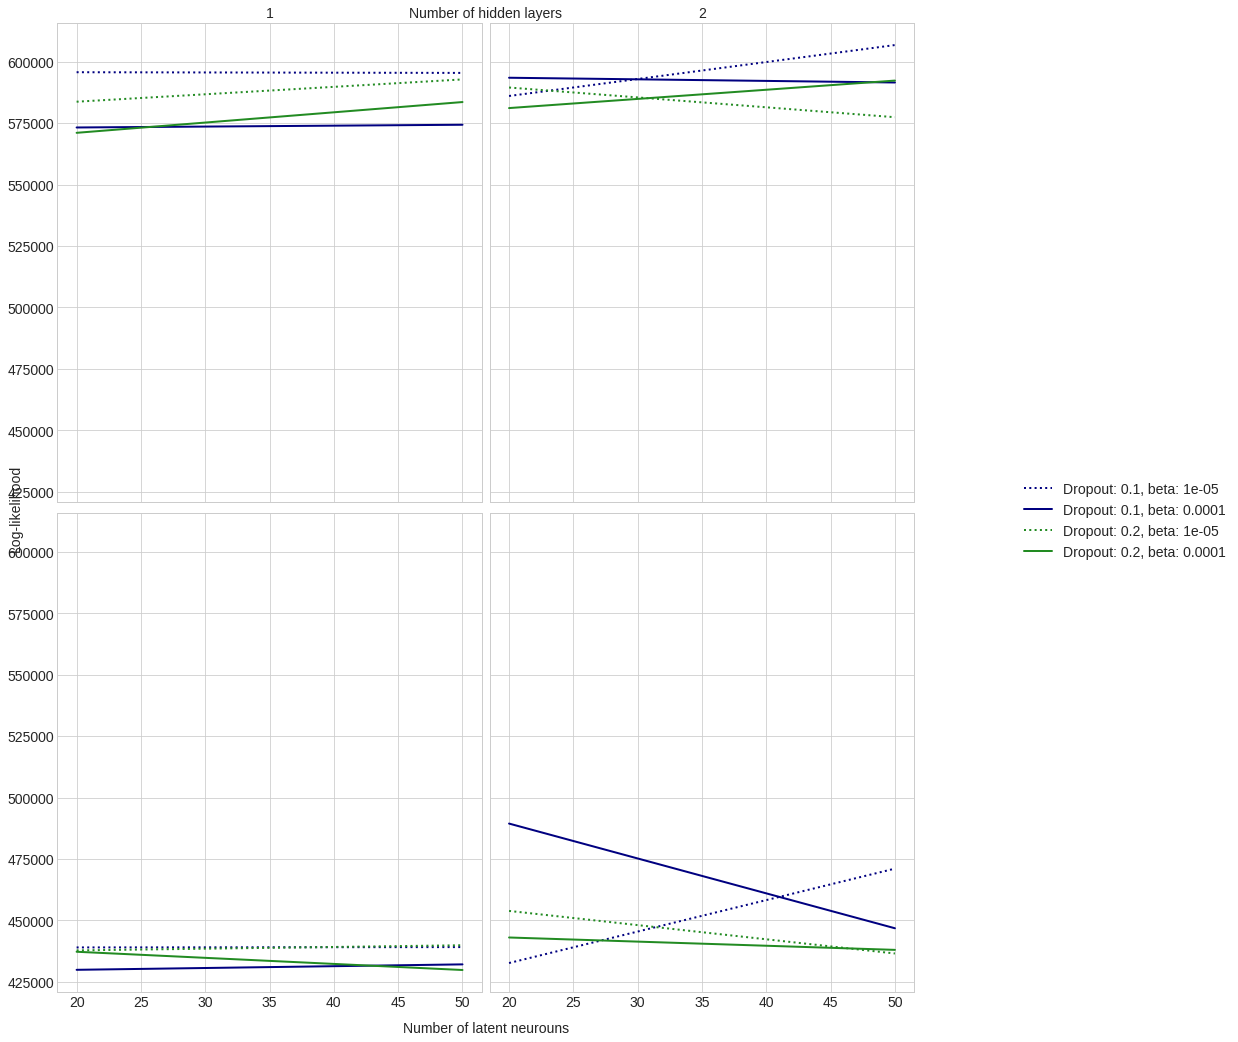

In [17]:
# Figure for test error/likelihood

# fig, axes = plt.subplots(3, 3, figsize=(18,15), sharex=True, sharey=True, frameon=False)
fig, axes = plt.subplots(2, 2, figsize=(18,15), sharex=True, sharey=True, frameon=False) # Changed n of subplots
ax3 = fig.add_subplot(111, frameon=False)
ax3.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_xlabel('Number of latent neurouns', fontsize = 14)
ax3.set_ylabel('Log-likelihood', fontsize = 14)
ax3.set_title('Number of hidden layers', fontsize = 14)
ax3.title.set_position([.5, 1.03])
ax3.yaxis.set_label_coords(-0.04, 0.5)
ax3.xaxis.set_label_coords(0.5, -0.03)
plt.grid(False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
x = 0
y = 0
# print(likelihood_tests)

for nl in nLayers:
   x = 0
   for nHidden in nHiddens:
      for drop in nDropout:
         c = ncols[nDropout.index(drop)]
         for b in nBeta:
            s = styles[nBeta.index(b)]
            
            d = []
            for nLatent in nLatents:
               combi = str([nHidden] * nl) + "+" + str(nLatent) + ", drop: " + str(drop) + \
                       ", b: " + str(b) + ", batch: " + str(batch_size)
               d.append(likelihood_tests[combi][0])

            a = axes[x,y].plot(nLatents, d,label= 'Dropout: ' + str(drop) +
                               ', beta: ' + str(b), linestyle=s, color = c, linewidth=2)
            
      if y == 2:
         axes[x,y].annotate(nHidden, xy=(1.02, 0.55), xycoords='axes fraction',
                            fontsize = 14, rotation=-90)
         
         if x == 1:
            axes[x,y].annotate('Number of hidden neurons in each layer',
                               xy=(1.1, 0.95), xycoords='axes fraction', 
                               fontsize = 14, rotation=-90)
      
      if x == 0:
         axes[x,y].set_title(nl, fontsize = 14)
      
#       axes[x,y].set(xlim=(10, 400), ylim=(360, 460)) # Took out xlim, ylim
      axes[x,y].xaxis.set_tick_params(labelsize=14)
      axes[x,y].yaxis.set_tick_params(labelsize=14)
      plt.xticks(nLatents, nLatents, fontsize=14)
      
      x += 1
   
   y += 1

plt.tight_layout()
# plt.subplot_tool()
fig.subplots_adjust(right=0.75)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize = 14)
plt.savefig(path + "hyperparameters/all_likelihoods_test1.png")

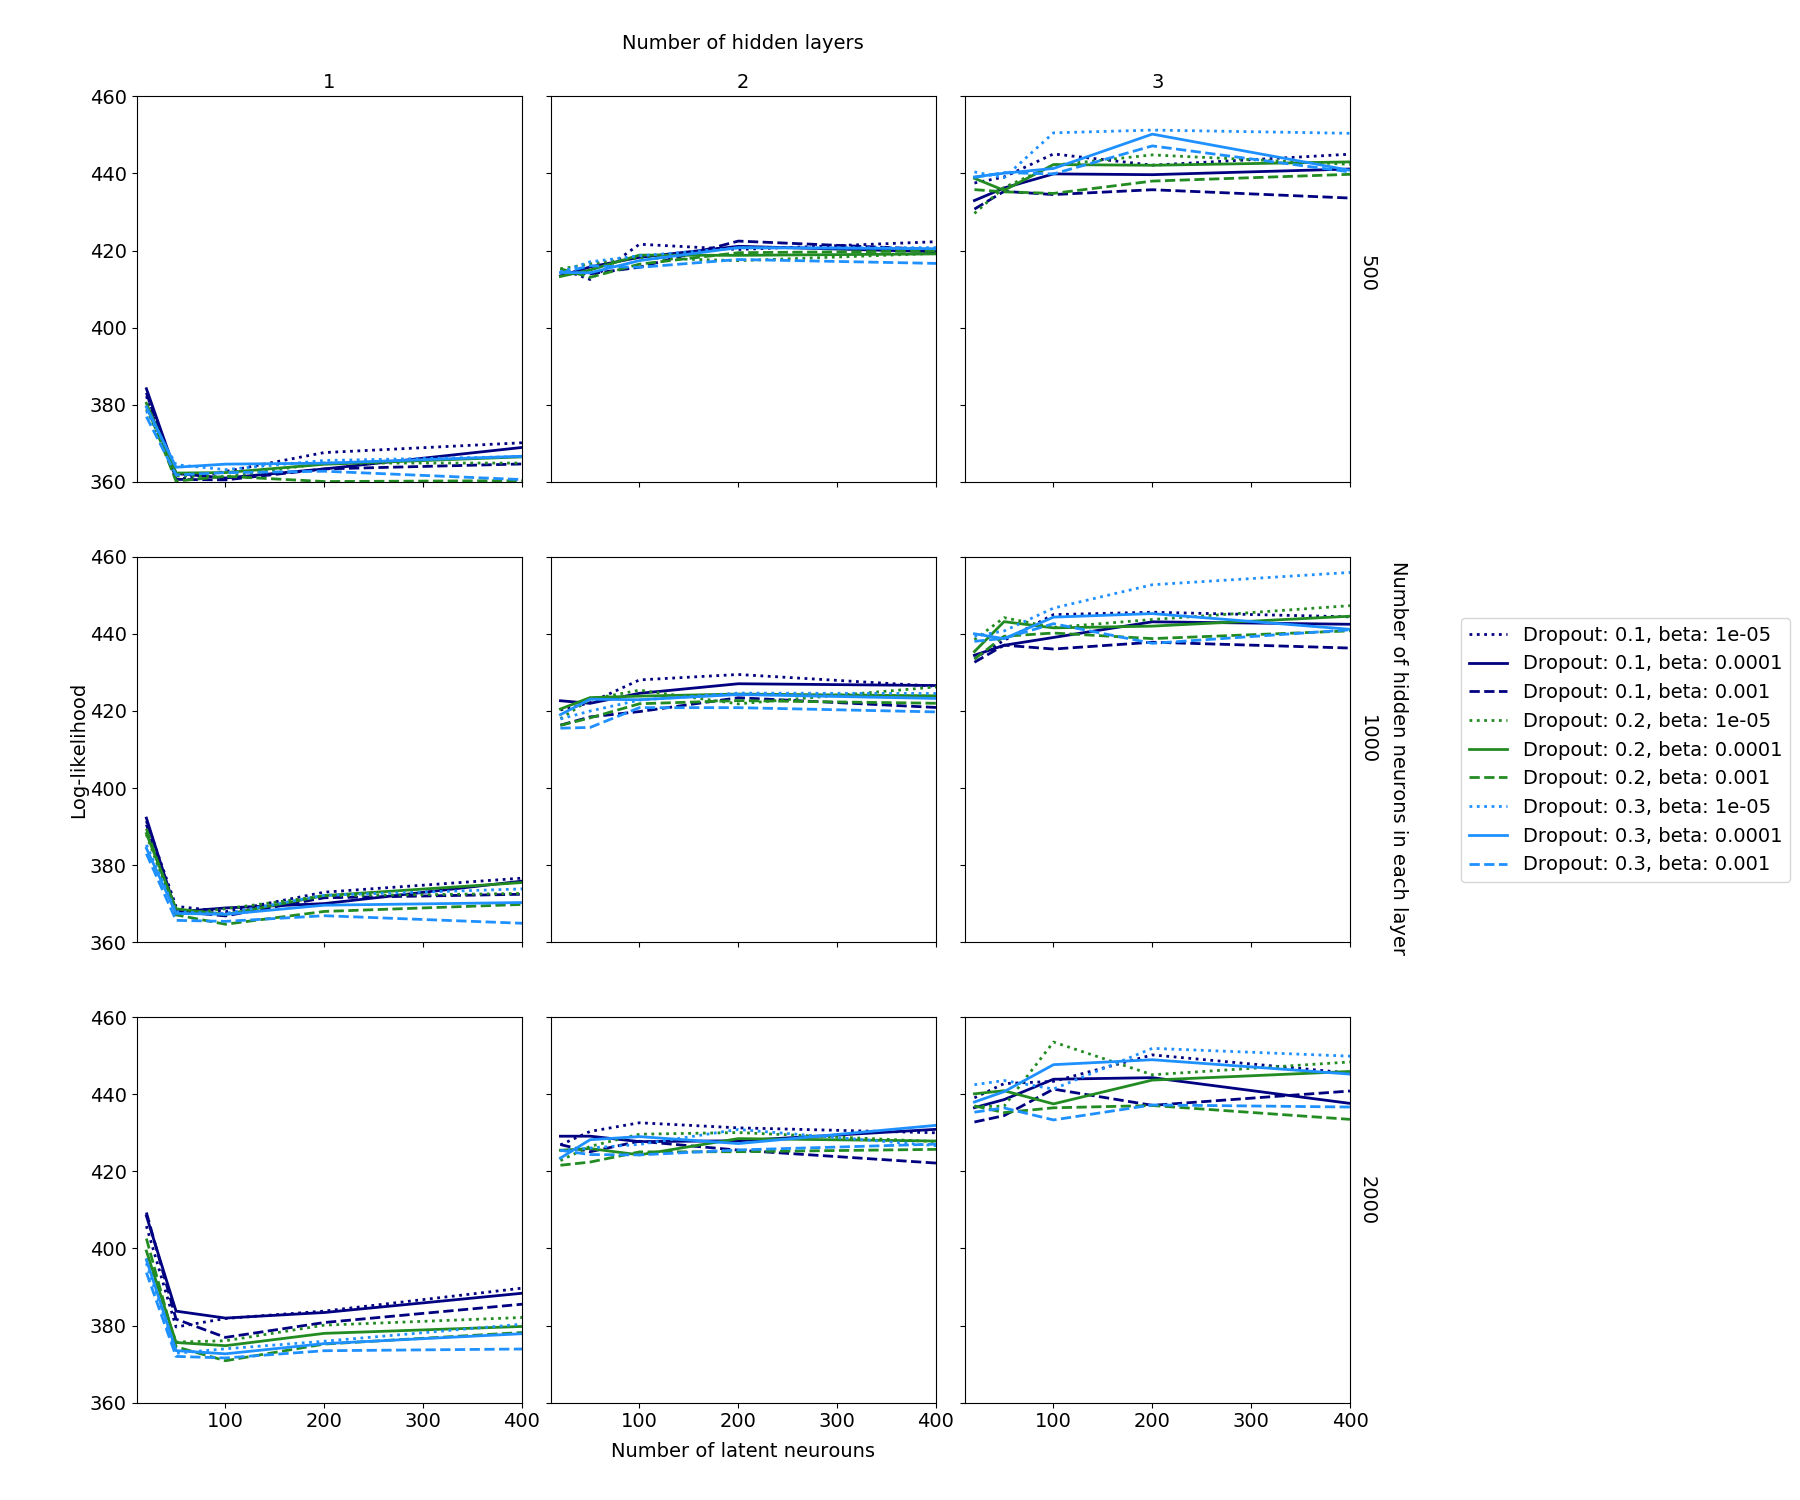

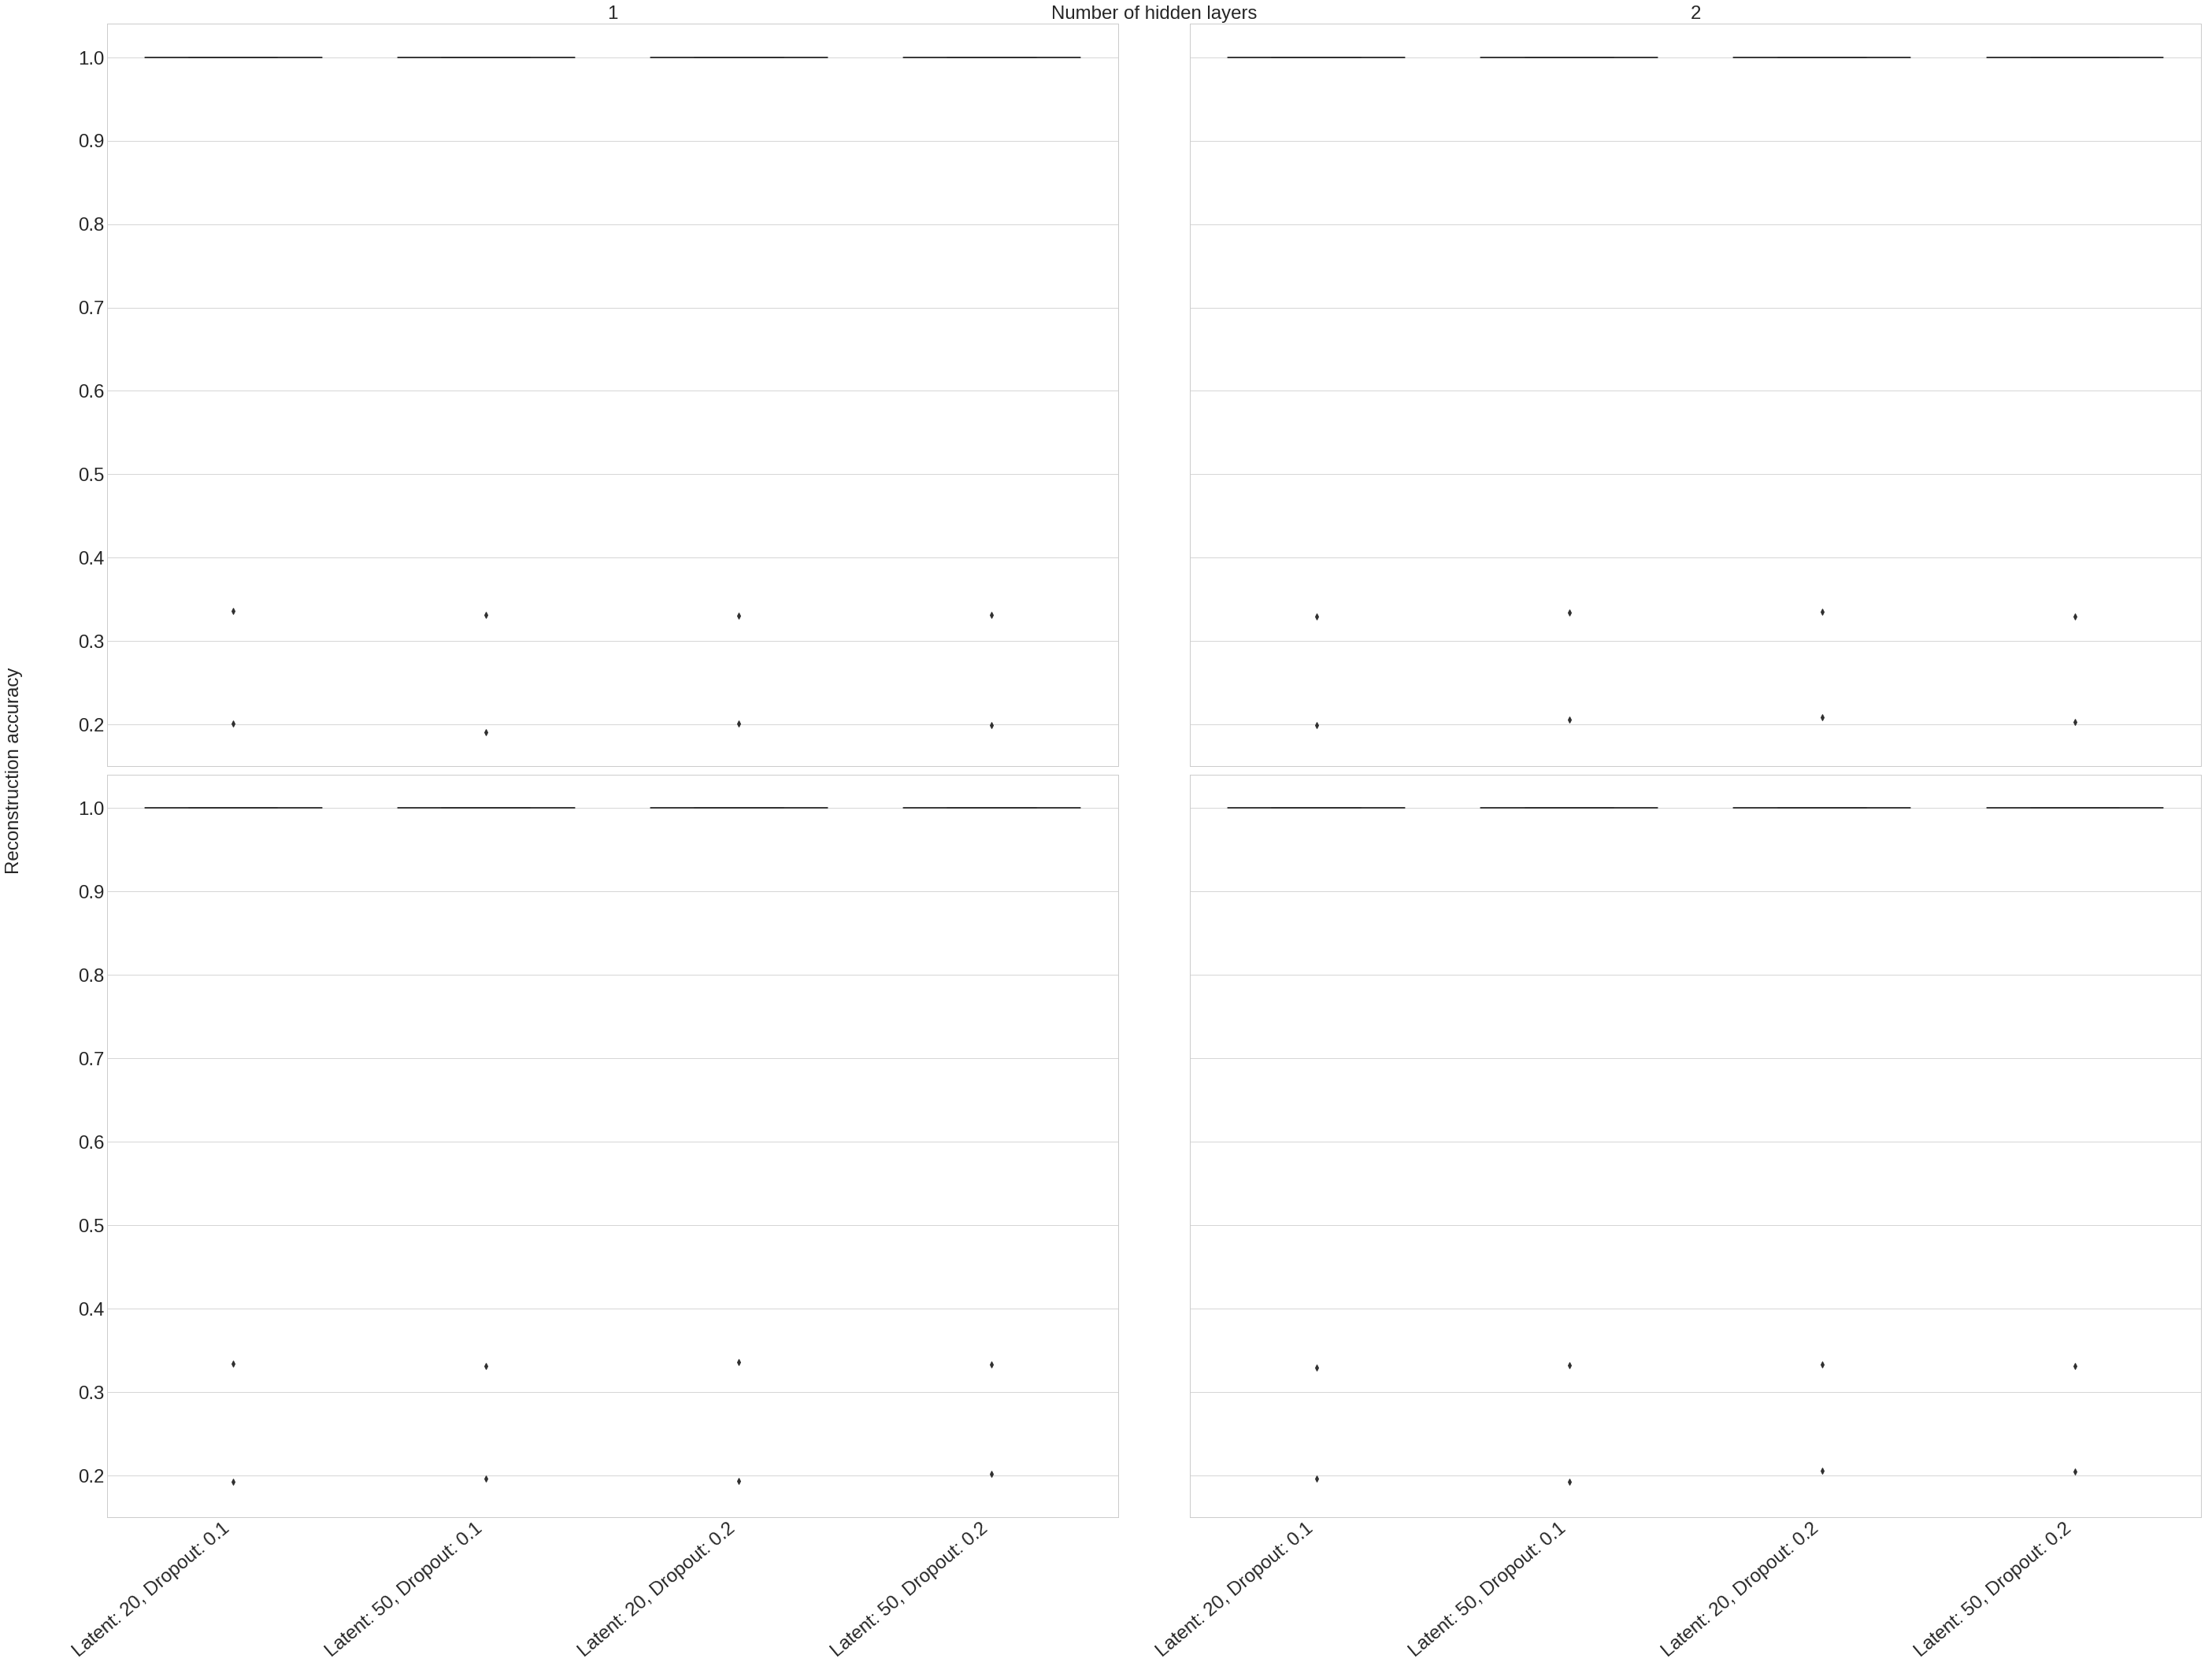

In [18]:
#Plot figure with test reconstructtion 
# fig, axes = plt.subplots(3, 3, figsize=(40,30), sharex=True, sharey=True, frameon=False)
fig, axes = plt.subplots(2, 2, figsize=(40,30), sharex=True, sharey=True, frameon=False)
ax3 = fig.add_subplot(111, frameon=False)
ax3.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_ylabel('Reconstruction accuracy', fontsize = 24)
ax3.set_title('Number of hidden layers', fontsize = 24)
ax3.title.set_position([.5, 1.03])
ax3.yaxis.set_label_coords(-0.04, 0.5)
ax3.xaxis.set_label_coords(0.5, -0.03)
plt.grid(False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

x = 0
y = 0

# nHiddens = [500, 1000, 2000]
# nLatents = [20, 50, 100, 200]
# nLayers = [1, 2, 3]
# nDropout = [0.1, 0.3]


nBeta = [0.0001]
for nl in nLayers:
   x = 0
   for nHidden in nHiddens:
      frame = pd.DataFrame()
      indexes = []
      for drop in nDropout:
         for b in nBeta:
            #s = styles[nBeta.index(b)]
            for nLatent in nLatents:
               combi = str([nHidden] * nl) + "+" + str(nLatent) + ", drop: " + str(drop) + ", b: " + str(b) + ", batch: " + str(batch_size)
            
               r = recon_acc_tests[combi][0]
               name = 'Latent: ' + str(nLatent) + ', Dropout: ' + str(drop)
               #name = 'Latent: ' + str(nLatent) + 'Dropout: ' + str(drop) + ', beta: ' + str(b)
               indexes.append(name)
               frame[combi] = r

            
      frame.set_axis(indexes, axis=1, inplace=True)
      sns.boxplot(data=frame, palette="colorblind", width=0.7, ax = axes[x,y])
                        
      if y == 2:
         axes[x,y].annotate(nHidden, xy=(1.02, 0.55), xycoords='axes fraction', fontsize = 24, rotation=-90)
         
         if x == 1:
            axes[x,y].annotate('Number of hidden neurons in each layer', xy=(1.1, 0.95), xycoords='axes fraction', fontsize = 24, rotation=-90)
      
      if x == 0:
         axes[x,y].set_title(nl, fontsize = 24)
      
      axes[x,y].set_xticklabels(indexes,fontsize=24, rotation=40, ha="right")
      axes[x,y].yaxis.set_tick_params(labelsize=24)
      
      x += 1
   
   y += 1

plt.tight_layout()
plt.savefig(path + "hyperparameters/benchmark_all_recon_test1.png")
plt.show()
# plt.clf()

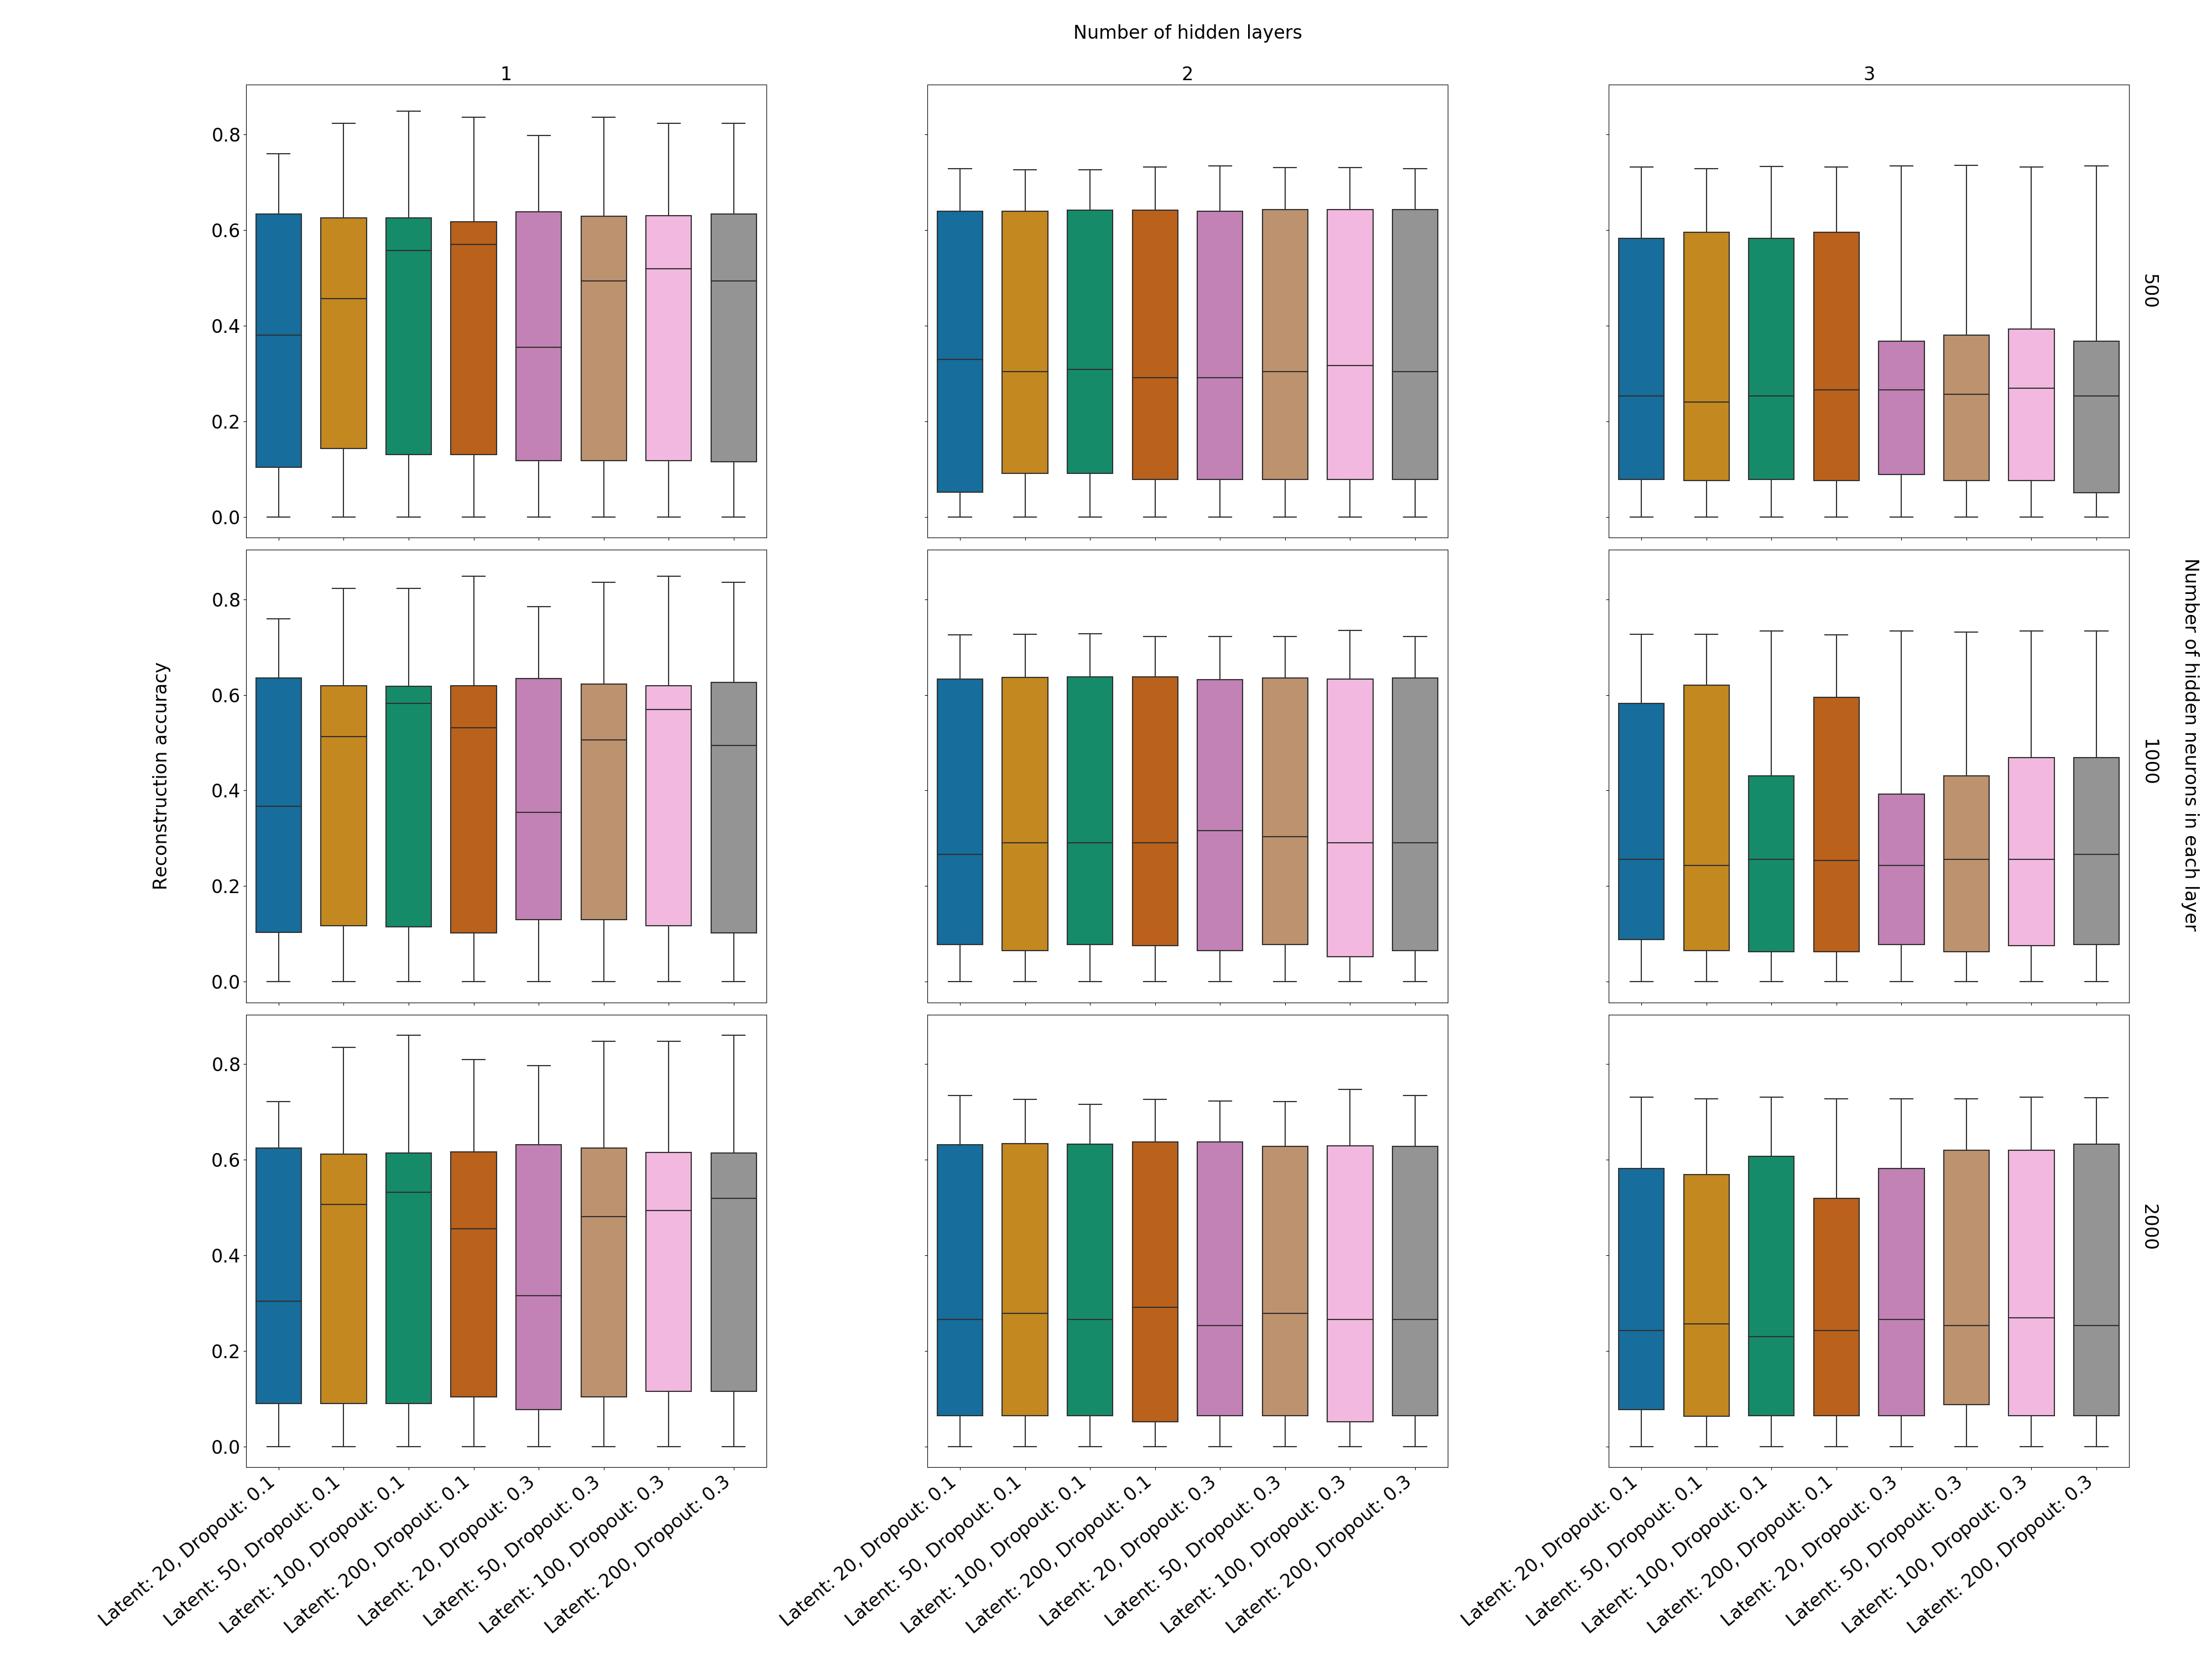

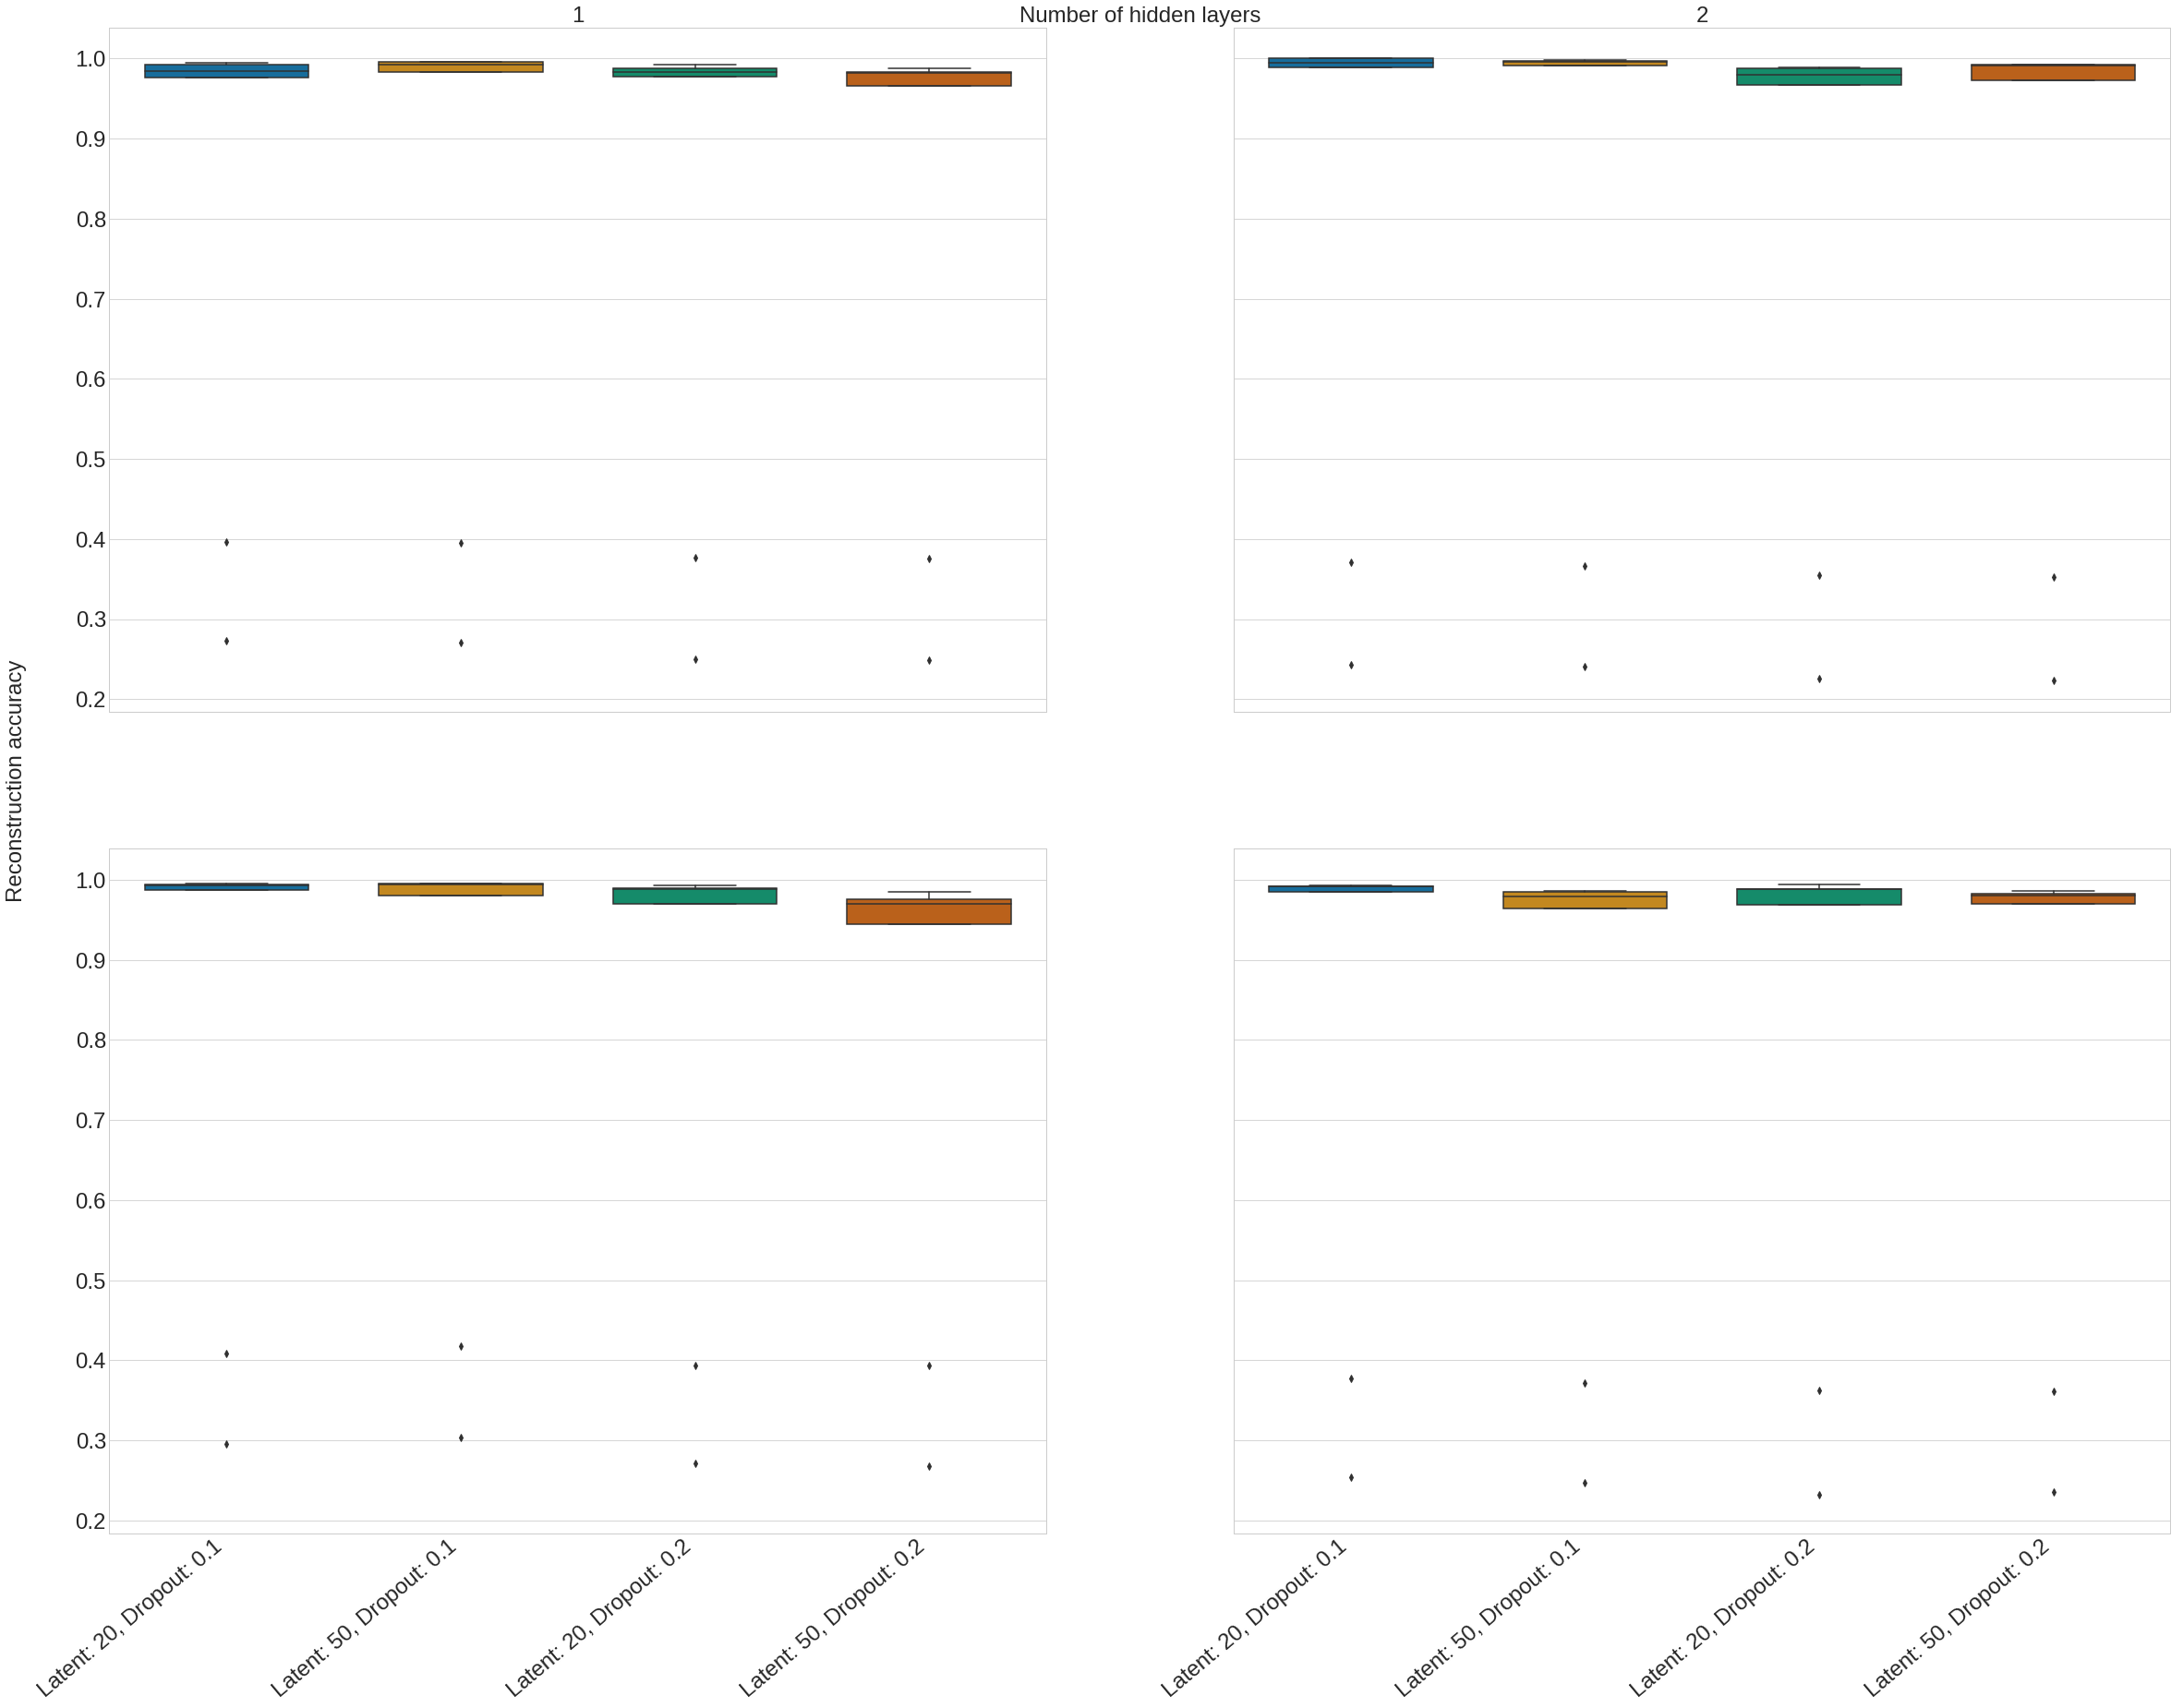

In [24]:
# Plot results for train reconstructions
fig, axes = plt.subplots(2, 2, figsize=(40,30), sharex=True, sharey=True, frameon=False)
ax3 = fig.add_subplot(111, frameon=False)
ax3.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_ylabel('Reconstruction accuracy', fontsize = 24)
ax3.set_title('Number of hidden layers', fontsize = 24)
ax3.title.set_position([.5, 1.03])
ax3.yaxis.set_label_coords(-0.04, 0.5)
ax3.xaxis.set_label_coords(0.5, -0.03)
plt.grid(False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

x = 0
y = 0

# nHiddens = [500, 1000, 2000]
# nLatents = [20, 50, 100, 200]
# nLayers = [1, 2, 3]
# nDropout = [0.1, 0.3]
nBeta = [0.0001] # Beta didn't really effect the results so for the reconstructions we only looked at one value

# print(recon_acc)
# print(recon_acc_tests)
for nl in nLayers:
   x = 0
   for nHidden in nHiddens:
      frame = pd.DataFrame()
      indexes = []
      for drop in nDropout:
         #c = ncols[nDropout.index(drop)]
         for b in nBeta:
            #s = styles[nBeta.index(b)]
            for nLatent in nLatents:
               combi = str([nHidden] * nl) + "+" + str(nLatent) + ", drop: " + str(drop) + ", b: " + str(b) + ", batch: " + str(batch_size)
#                print(combi)
               try:
                  r = recon_acc[combi][0]
               except:
                  r = 0 
               name = 'Latent: ' + str(nLatent) + ', Dropout: ' + str(drop)
               #name = 'Latent: ' + str(nLatent) + 'Dropout: ' + str(drop) + ', beta: ' + str(b)
               indexes.append(name)
               frame[combi] = r
      
      frame.set_axis(indexes, axis=1, inplace=True)
      sns.boxplot(data=frame, palette="colorblind", width=0.7, ax = axes[x,y])                        
      if y == 2:
         axes[x,y].annotate(nHidden, xy=(1.02, 0.55), xycoords='axes fraction', fontsize = 24, rotation=-90)
         
         if x == 1:
            axes[x,y].annotate('Number of hidden neurons in each layer', xy=(1.1, 0.95), xycoords='axes fraction', fontsize = 24, rotation=-90)
      
      if x == 0:
         axes[x,y].set_title(nl, fontsize = 24)
      
      axes[x,y].set_xticklabels(indexes,fontsize=24, rotation=40, ha="right")
      axes[x,y].yaxis.set_tick_params(labelsize=24)
      
      x += 1
   
   y += 1

# plt.tight_layout()

plt.savefig(path + "hyperparameters/all_recon_train1.png")
plt.show()

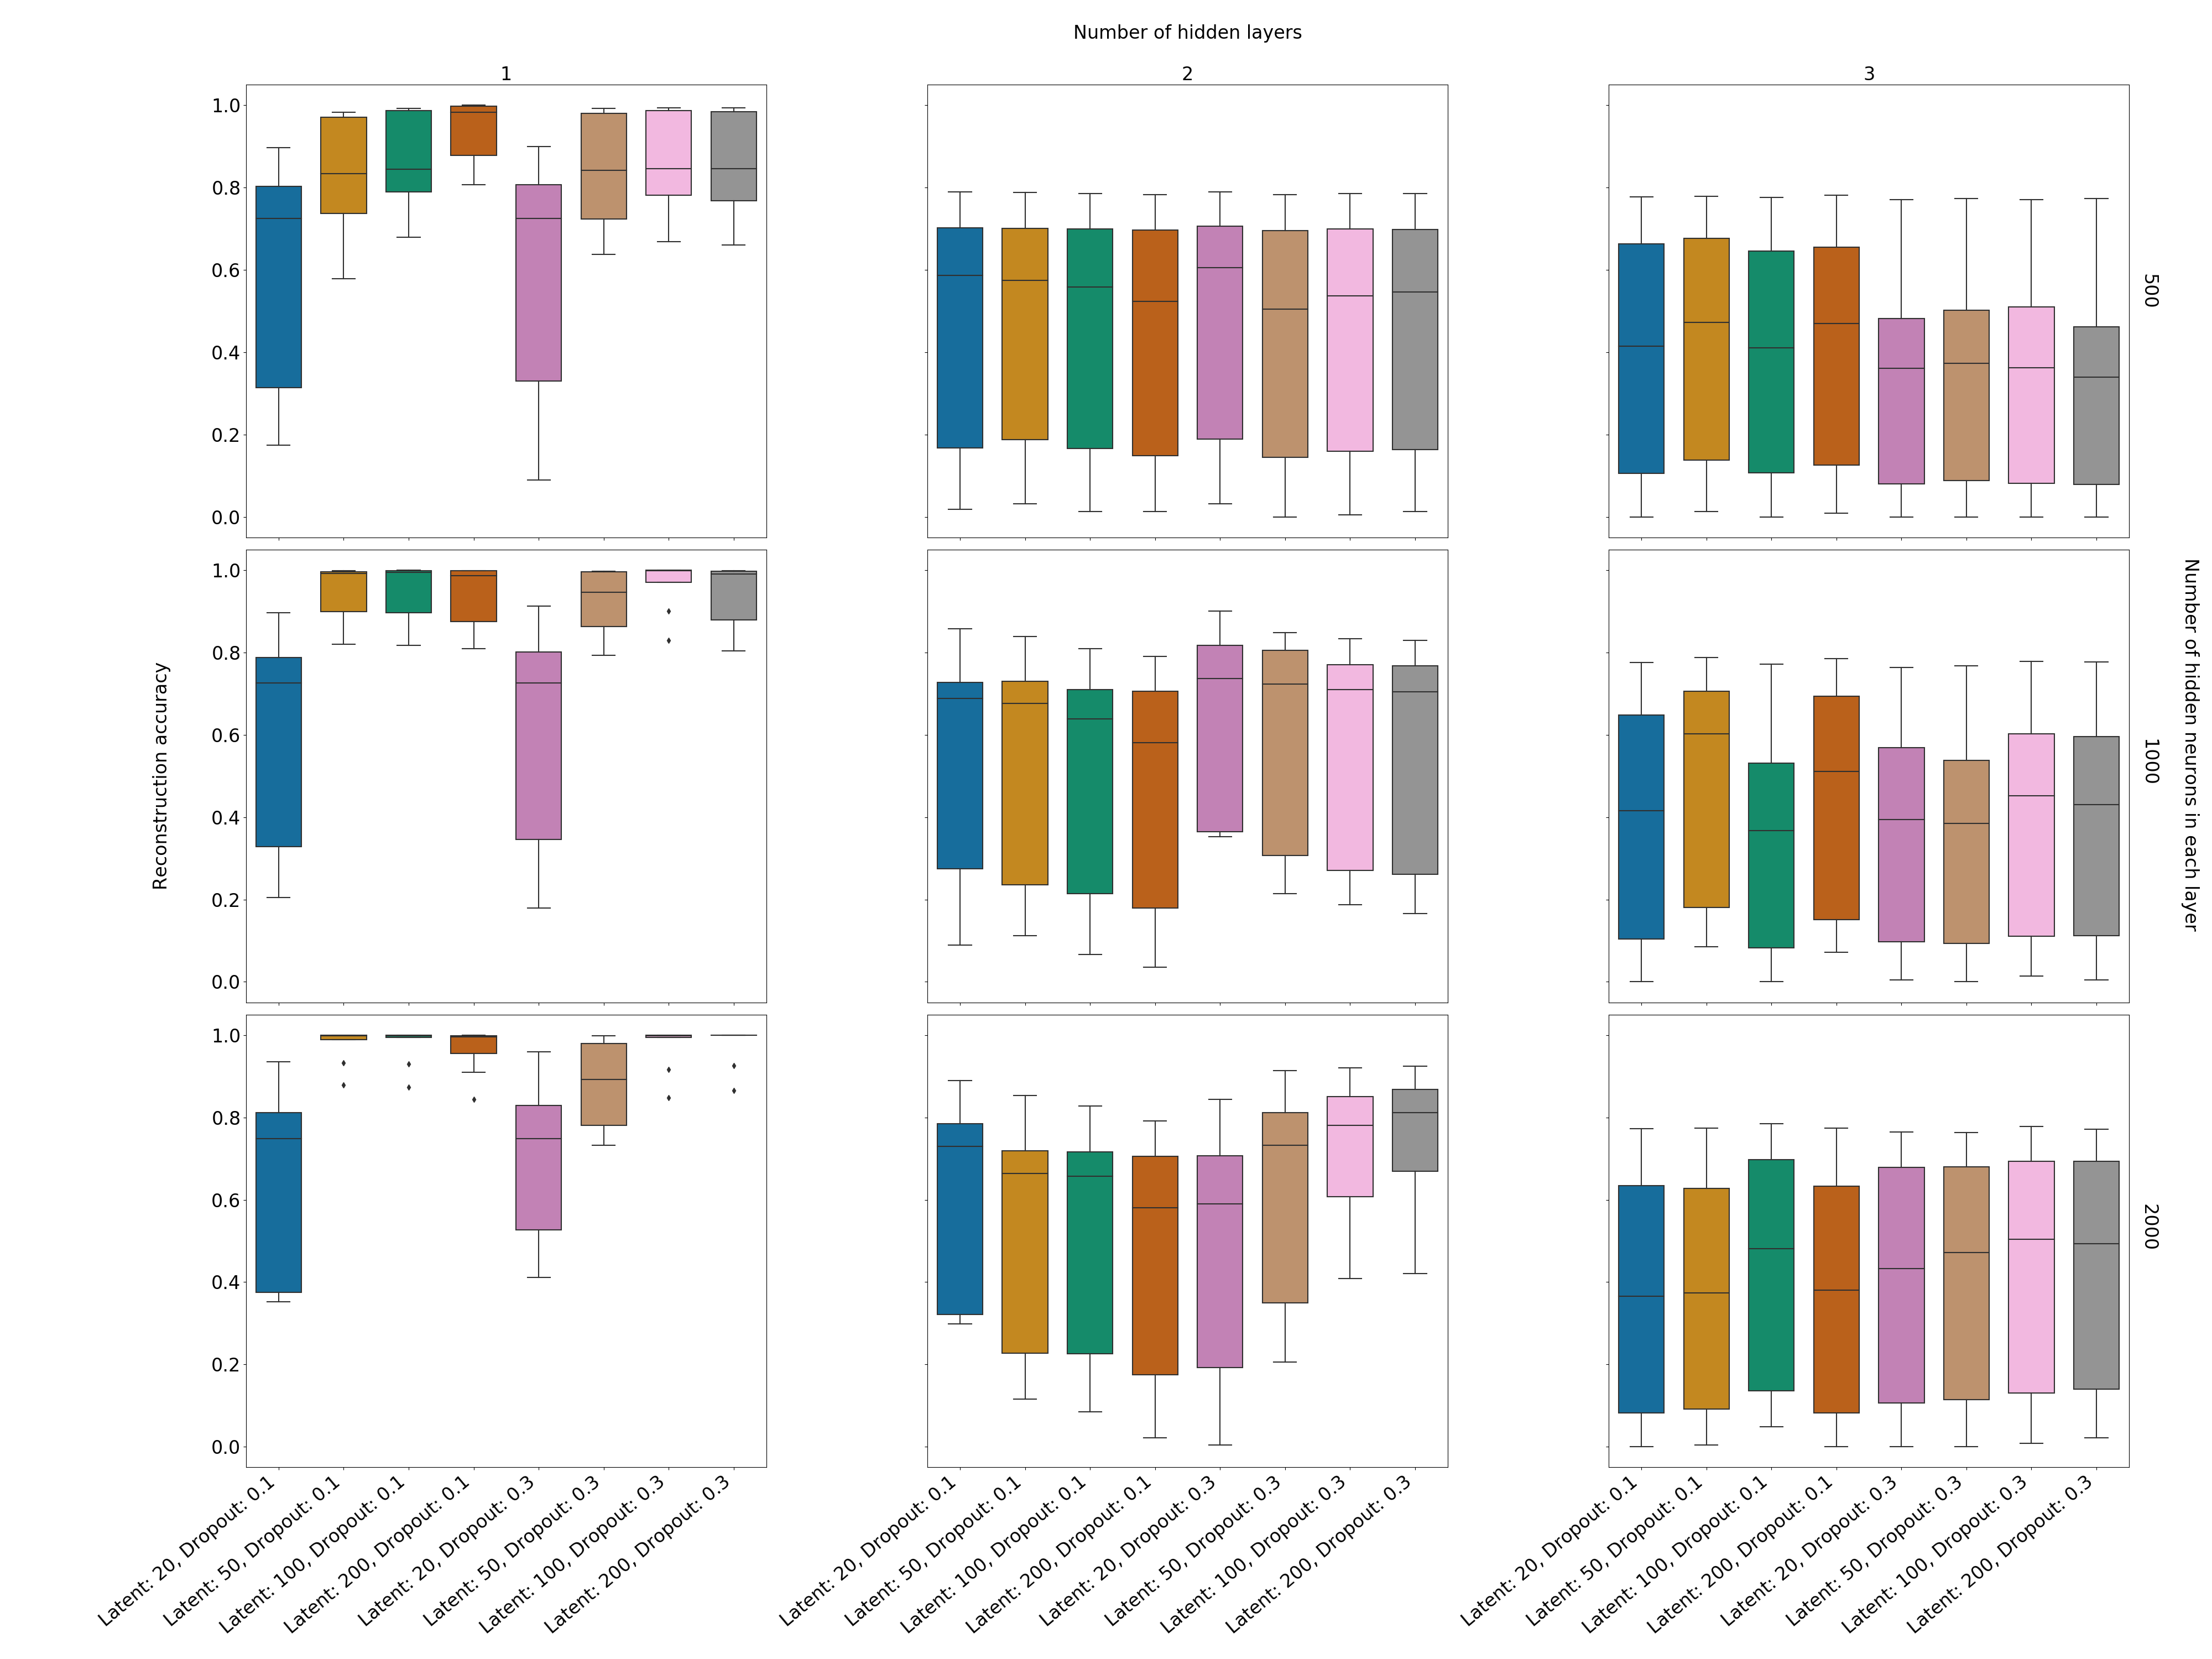

Based on these results we for our method went along with testing the method for stability using one hidden layer, for stablity with repeated training using the code in "<i>VAE_hyperparameter_optimization_stability.ipynb</i>"

In [20]:
# For some reason there is 48 elements in recon_acc, with some elements that are empty
# Make the number of figures based on num of hyperparameters
# set_ranges based on the data
# num_loaders is possible only on with gpu
# Changed patience to 10, instead of 100, and less hyperparameters for faster training for now